In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels as sm
import json
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.metrics.cluster import completeness_score
from collections import Counter
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
N_CLASSES = 7 # Number of different neuron cell types

Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5047377/

# Data loading and pre-processing

In [4]:
PATH = "./data/"

NORMALIZED_CPM = "GSE74989_NormalizedCPMcorrectedData.txt"
COGNITION_GENE_NAMES = "FlyBase_Fields_download.txt"

In [5]:
# Names of genes related to cognition from FlyBase (names converted on flybase.org directly)
cognition_genes = pd.read_csv(PATH + COGNITION_GENE_NAMES, delimiter = '\t')
cognition_genes.head()

,#SUBMITTED ID,FBID_KEY,NAME,SYMBOL
0,FBgn0000017,FBgn0000017,Abl tyrosine kinase,Abl
1,FBgn0000108,FBgn0000108,beta amyloid protein precursor-like,Appl
2,FBgn0000117,FBgn0000117,armadillo,arm
3,FBgn0000119,FBgn0000119,arrow,arr
4,FBgn0000229,FBgn0000229,basket,bsk


In [6]:
# Store the gene names in a list
cognition_genes['SYMBOL'] = cognition_genes['SYMBOL']#.str.lower()
cognition_gene_names = list(cognition_genes['SYMBOL'])

In [7]:
# Normalized and corrected CPMs data
normalized_CPM = pd.read_csv(PATH + NORMALIZED_CPM, delimiter = '\t')
normalized_CPM['genes'] = normalized_CPM['genes']#.str.lower()
normalized_CPM

,genes,DAL1,DAL2,DAL3,DAL4,DAL5,DAL6,DAL7,DAL8,DAL9,...,V2_WF_1,V3_WF_2,c739_WF_4,R27_WF_2,V3_WF_4,V3_WF_1,R27_WF_4,c739_WF_1,V2_WF_4,R27_WF_3
0,40421,6.438726,6.644547,8.508330,6.403910,7.316690,4.812674,6.449898,7.245511,7.342647,...,8.431248,8.519282,7.953327,8.109764,7.602672,8.097901,8.066697,7.906801,7.693086,8.051062
1,40422,8.767724,7.310645,6.804362,7.528005,9.712675,7.528979,8.244501,9.296301,9.493352,...,9.509494,9.493940,9.471764,8.856065,9.030290,9.386430,9.484332,9.495526,9.322852,9.212647
2,40424,9.172041,8.336886,9.132409,9.166373,8.763639,9.969343,10.067098,9.695699,8.553539,...,7.499071,7.642772,7.767471,8.359990,7.318375,7.547994,7.762947,7.906684,7.759270,7.818983
3,40425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.834598,5.811424,5.818114,5.466807,4.060516,6.262409,5.372833,5.964265,4.198261,5.675554
4,40512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.649868,9.592839,7.860096,8.515480,12.313459,7.240659,9.362268,9.138202,8.172130,12.842548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15677,zuc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.241134,4.839252,4.746360,5.706368,3.587946,5.350011,4.789200,5.537051,4.170294,5.536865
15678,Zw,6.039009,2.498927,2.043417,4.409347,2.963707,3.048745,1.718670,4.042022,3.981873,...,7.117309,7.349993,7.898549,8.320775,8.090096,7.573029,7.792276,7.060101,8.246744,6.606420
15679,zwilch,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.988556,7.280553,7.226536,4.077231,5.312497,7.966692,5.968812,7.361138,6.065411,7.379316
15680,zye,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.928987,-0.211979,2.323082,0.168492,2.905512,-0.239483,-0.233951,1.767057,5.734309,-0.056862


In [8]:
normalized_CPM = normalized_CPM.loc[~(normalized_CPM==0).all(axis=1)]
normalized_CPM

,genes,DAL1,DAL2,DAL3,DAL4,DAL5,DAL6,DAL7,DAL8,DAL9,...,V2_WF_1,V3_WF_2,c739_WF_4,R27_WF_2,V3_WF_4,V3_WF_1,R27_WF_4,c739_WF_1,V2_WF_4,R27_WF_3
0,40421,6.438726,6.644547,8.508330,6.403910,7.316690,4.812674,6.449898,7.245511,7.342647,...,8.431248,8.519282,7.953327,8.109764,7.602672,8.097901,8.066697,7.906801,7.693086,8.051062
1,40422,8.767724,7.310645,6.804362,7.528005,9.712675,7.528979,8.244501,9.296301,9.493352,...,9.509494,9.493940,9.471764,8.856065,9.030290,9.386430,9.484332,9.495526,9.322852,9.212647
2,40424,9.172041,8.336886,9.132409,9.166373,8.763639,9.969343,10.067098,9.695699,8.553539,...,7.499071,7.642772,7.767471,8.359990,7.318375,7.547994,7.762947,7.906684,7.759270,7.818983
3,40425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.834598,5.811424,5.818114,5.466807,4.060516,6.262409,5.372833,5.964265,4.198261,5.675554
4,40512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.649868,9.592839,7.860096,8.515480,12.313459,7.240659,9.362268,9.138202,8.172130,12.842548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15677,zuc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.241134,4.839252,4.746360,5.706368,3.587946,5.350011,4.789200,5.537051,4.170294,5.536865
15678,Zw,6.039009,2.498927,2.043417,4.409347,2.963707,3.048745,1.718670,4.042022,3.981873,...,7.117309,7.349993,7.898549,8.320775,8.090096,7.573029,7.792276,7.060101,8.246744,6.606420
15679,zwilch,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.988556,7.280553,7.226536,4.077231,5.312497,7.966692,5.968812,7.361138,6.065411,7.379316
15680,zye,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.928987,-0.211979,2.323082,0.168492,2.905512,-0.239483,-0.233951,1.767057,5.734309,-0.056862


In [9]:
normalized_CPM['genes'].duplicated().any() # No duplicated genes

False

In [10]:
#normalized_CPM[normalized_CPM['genes'] == 'Ald']

In [11]:
#normalized_CPM[normalized_CPM['genes'] == 'ald']

In [12]:
print(normalized_CPM.columns) # The last columns are whole fly samples

Index(['genes', 'DAL1', 'DAL2', 'DAL3', 'DAL4', 'DAL5', 'DAL6', 'DAL7', 'DAL8',
       'DAL9', 'DAL10', 'V2_1', 'V2_2', 'V2_3', 'V2_4', 'V2_5', 'V2_6', 'V2_7',
       'V2_8', 'V2_9', 'V2_10', 'AB_KCs1', 'AB_KCs2', 'AB_KCs3', 'AB_KCs4',
       'AB_KCs5', 'AB_KCs6', 'AB_KCs7', 'AB_KCs8', 'AB_KCs9', 'AB_KCs10',
       'G_KCs1', 'G_KCs2', 'G_KCs3', 'G_KCs4', 'G_KCs5', 'G_KCs6', 'G_KCs7',
       'G_KCs8', 'G_KCs9', 'G_KCs10', 'G_KCs11', 'G_KCs12', 'V3_1', 'V3_2',
       'V3_3', 'V3_4', 'V3_5', 'V3_6', 'V3_7', 'V3_8', 'V3_9', 'V3_10',
       'R27_1', 'R27_2', 'R27_3', 'R27_4', 'R27_5', 'R27_6', 'R27_7', 'R27_8',
       'G386_1', 'G386_2', 'G386_3', 'G386_4', 'G386_5', 'G386_6', 'G386_7',
       'G386_8', 'G386_9', 'Fly1_GFP', 'Fly2_GFP', 'Fly3_GFP', 'NP1131_WF_1',
       'DAL_WF_3', 'G368_WF_2', 'G368_WF_4', 'G368_WF_1', 'DAL_WF_1',
       'NP1131_WF_4', 'DAL_WF_4', 'NP1131_WF_3', 'V2_WF_2', 'DAL_WF_2',
       'G386_WF_3', 'NP1131_WF_2', 'c739_WF_2', 'V2_WF_1', 'V3_WF_2',
       'c739_WF_4',

In [13]:
# Keep only data about genes related to cognition
cognition_data = normalized_CPM[normalized_CPM['genes'].isin(cognition_gene_names)].copy()

# Neuron samples (remove whole fly samples)
neuron_samples_cognition = cognition_data[cognition_data.columns[:70]].copy()
neuron_samples_cognition.head()

,genes,DAL1,DAL2,DAL3,DAL4,DAL5,DAL6,DAL7,DAL8,DAL9,...,R27_8,G386_1,G386_2,G386_3,G386_4,G386_5,G386_6,G386_7,G386_8,G386_9
8,14-3-3zeta,14.212799,14.260488,14.514515,14.834518,14.645589,14.314489,15.025555,14.435693,14.545007,...,14.286638,14.354743,14.384019,14.660608,14.178927,13.846655,14.756887,14.224475,14.591677,14.048766
11,2mit,9.262948,10.448570,9.739787,10.992330,10.625359,10.410979,11.144486,10.078055,10.341885,...,11.203543,10.551383,10.265070,10.115959,10.673057,10.422510,10.096259,10.215157,11.039479,10.038356
14,5-HT1A,7.083970,6.178956,8.598664,8.999477,6.751247,8.531064,8.959349,8.052809,7.805503,...,9.988427,10.220667,9.248527,10.252560,10.157292,10.918050,10.072357,8.538728,10.380630,7.471208
158,Abl,7.130445,8.389671,7.452564,7.770638,6.818213,6.793310,7.456179,7.970737,7.286042,...,7.120569,4.941310,5.441138,7.617468,8.501829,7.583315,4.946458,4.845335,7.674819,5.226706
227,Adf1,9.373477,7.966143,7.359539,8.510149,8.694008,8.785664,9.448633,9.122803,9.330528,...,8.263544,5.862244,6.384412,5.989058,8.206436,7.258962,9.052937,8.883719,5.896699,9.418155


In [14]:
# Most variable genes retained in the previous analysis of DGRP lines transcription data
with open(PATH + 'top_variable_genes_cognition.json') as json_file:
    top_cognition_genes = json.load(json_file)['cognition'] # cognition (not learning nor memory)
    
print(top_cognition_genes) 

['FBgn0004419', 'FBgn0038934', 'FBgn0003165', 'FBgn0000273', 'FBgn0004101', 'FBgn0004864', 'FBgn0004370', 'FBgn0043903', 'FBgn0030812', 'FBgn0003502']


In [15]:
# Most variable genes related to cognition
top_cognition_neuron_gene_names = cognition_genes[cognition_genes['FBID_KEY'].isin(top_cognition_genes)]['SYMBOL'].to_list()
print(top_cognition_neuron_gene_names)

# Neuron samples with these most variable genes only
top_cognition_neuron_samples = normalized_CPM[normalized_CPM['genes'].isin(top_cognition_neuron_gene_names)].copy()
top_cognition_neuron_samples = top_cognition_neuron_samples[top_cognition_neuron_samples.columns[:70]].copy() # only neuron samples
top_cognition_neuron_samples.head()

['Pka-C1', 'pum', 'Btk29A', 'bs', 'Ptp10D', 'me31B', 'hop', 'wcy', 'Gld2', 'dome']


,genes,DAL1,DAL2,DAL3,DAL4,DAL5,DAL6,DAL7,DAL8,DAL9,...,R27_8,G386_1,G386_2,G386_3,G386_4,G386_5,G386_6,G386_7,G386_8,G386_9
656,bs,1.935444,1.941303,3.161840,3.922741,4.663298,6.196490,5.651950,4.087947,1.924799,...,1.946079,2.034846,2.864201,1.951490,1.924568,1.931067,4.010218,3.953652,1.928075,2.701478
669,Btk29A,6.406019,7.389764,8.884758,8.026315,8.276821,8.055775,8.411377,8.721376,8.127390,...,8.345949,6.882186,8.177492,6.884721,5.678511,7.060910,7.688488,8.263171,6.274097,6.010200
9843,dome,7.975098,6.953414,6.212854,6.891352,8.349425,7.449102,6.908600,6.235499,6.509982,...,3.644194,3.780189,7.910490,6.548929,5.841097,5.785247,6.381181,5.498707,7.585491,3.588306
10406,Gld2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10814,hop,7.401410,5.603299,3.729422,5.007611,6.357446,3.723385,6.942844,6.748738,6.778802,...,3.729551,3.764926,3.902527,6.006928,6.116605,6.560592,6.101827,6.913714,3.987639,3.796213


# 1) All genes related to cognition

## Average over samples of the same cell type

In [16]:
# Function to filter columns by neuron type and create a data frame of this specific neuron type
def filter_columns_starting_with(chars, df):
    filter_col = [col for col in df if col.startswith(chars)]
    filter_col.append('genes')
    filtered_df = df[filter_col].copy()
    filtered_df.set_index('genes', inplace=True)
    return filtered_df

In [17]:
# DAL neurons
DAL = filter_columns_starting_with('DAL', neuron_samples_cognition)
DAL.head()

,DAL1,DAL2,DAL3,DAL4,DAL5,DAL6,DAL7,DAL8,DAL9,DAL10
genes,,,,,,,,,,
14-3-3zeta,14.212799,14.260488,14.514515,14.834518,14.645589,14.314489,15.025555,14.435693,14.545007,14.738348
2mit,9.262948,10.448570,9.739787,10.992330,10.625359,10.410979,11.144486,10.078055,10.341885,10.561896
5-HT1A,7.083970,6.178956,8.598664,8.999477,6.751247,8.531064,8.959349,8.052809,7.805503,8.376943
Abl,7.130445,8.389671,7.452564,7.770638,6.818213,6.793310,7.456179,7.970737,7.286042,8.484229
Adf1,9.373477,7.966143,7.359539,8.510149,8.694008,8.785664,9.448633,9.122803,9.330528,9.430595


In [18]:
# V2 neurons
V2 = filter_columns_starting_with('V2', neuron_samples_cognition)
V2.head()

,V2_1,V2_2,V2_3,V2_4,V2_5,V2_6,V2_7,V2_8,V2_9,V2_10
genes,,,,,,,,,,
14-3-3zeta,14.762869,15.022403,14.998181,14.582752,14.882219,14.818527,15.410971,14.984568,15.442323,14.599997
2mit,10.700014,10.885510,11.012240,11.133219,10.671202,10.792150,11.251798,11.836473,10.909332,10.897625
5-HT1A,8.914915,9.052792,8.505493,8.926026,7.709673,9.297429,9.607277,9.370006,8.657968,8.891421
Abl,6.687163,8.080409,8.542088,8.541421,7.608932,8.486595,8.988646,8.788143,8.665743,8.174112
Adf1,8.535346,9.150829,8.958454,9.044509,8.808194,9.752632,9.349048,9.136887,9.200981,8.570923


In [19]:
# AB_KC neurons
AB_KC = filter_columns_starting_with('AB_KC', neuron_samples_cognition)
AB_KC.head()

,AB_KCs1,AB_KCs2,AB_KCs3,AB_KCs4,AB_KCs5,AB_KCs6,AB_KCs7,AB_KCs8,AB_KCs9,AB_KCs10
genes,,,,,,,,,,
14-3-3zeta,16.198555,16.082893,15.980344,15.548601,15.923389,15.496965,15.952848,15.477261,15.723196,16.211890
2mit,12.619833,12.589821,12.464198,12.087396,12.641895,13.284361,12.904643,11.827770,12.039530,12.496390
5-HT1A,10.538721,10.810057,10.291365,9.818444,10.347178,10.443678,10.528033,10.256446,9.923849,10.642790
Abl,9.210885,9.588791,8.691066,8.271019,8.612456,9.122549,9.360089,8.553709,8.904978,8.405464
Adf1,9.017093,9.115985,9.212139,9.517476,9.374108,9.282448,9.364772,9.106500,8.494319,9.227707


In [20]:
# G_KC neurons
G_KC = filter_columns_starting_with('G_KC', neuron_samples_cognition)
G_KC.head()

,G_KCs1,G_KCs2,G_KCs3,G_KCs4,G_KCs5,G_KCs6,G_KCs7,G_KCs8,G_KCs9,G_KCs10,G_KCs11,G_KCs12
genes,,,,,,,,,,,,
14-3-3zeta,16.109425,15.509095,15.431172,15.894105,15.894695,16.279108,15.768479,15.656343,15.677670,15.689005,16.118643,15.724394
2mit,12.103029,11.593373,11.959801,11.893004,12.205193,12.147074,11.822762,11.862776,11.632078,11.890531,11.929692,11.792357
5-HT1A,9.934605,9.190996,9.517403,9.764558,10.213020,10.278709,9.546863,9.838299,9.435557,9.734853,9.924781,9.831405
Abl,9.155782,8.781395,9.425618,8.757293,8.854941,8.710346,8.953970,9.427883,8.908252,8.892095,9.035591,8.412536
Adf1,8.957758,9.508139,9.695452,9.484228,9.374890,9.518020,9.297451,9.127827,9.301763,9.589301,9.426638,9.474412


In [21]:
# V3 neurons
V3 = filter_columns_starting_with('V3', neuron_samples_cognition)
V3.head()

,V3_1,V3_2,V3_3,V3_4,V3_5,V3_6,V3_7,V3_8,V3_9,V3_10
genes,,,,,,,,,,
14-3-3zeta,14.274257,14.613836,14.615734,14.670868,14.201453,14.581070,14.311559,14.819979,14.395327,14.288093
2mit,11.084278,11.461729,11.227063,8.029346,10.258421,11.000266,11.187886,10.671378,10.217554,10.788264
5-HT1A,7.574626,8.864113,7.872072,7.228260,8.553423,8.814597,9.706683,6.977421,9.213542,8.748898
Abl,6.827335,8.886683,7.781661,6.047213,7.672449,7.785358,7.638349,7.827068,7.351729,7.827995
Adf1,8.223317,8.477781,8.494360,9.231556,7.954586,9.045064,9.233670,8.595848,8.684427,8.590032


In [22]:
# R27 neurons
R27 = filter_columns_starting_with('R27', neuron_samples_cognition)
R27.head()

,R27_1,R27_2,R27_3,R27_4,R27_5,R27_6,R27_7,R27_8
genes,,,,,,,,
14-3-3zeta,14.011635,14.020047,14.261164,14.506730,14.326251,14.640702,14.161139,14.286638
2mit,10.828729,11.039649,10.188591,10.986821,10.928505,11.248626,10.351583,11.203543
5-HT1A,10.420319,9.658411,9.985297,10.270588,9.979399,11.249229,8.410470,9.988427
Abl,7.990026,7.241901,5.688744,8.418954,5.237454,5.139221,5.255088,7.120569
Adf1,8.234641,8.150660,5.948498,7.965140,7.677621,5.855134,9.814928,8.263544


In [23]:
# G386 neurons
G386 = filter_columns_starting_with('G386', neuron_samples_cognition)
G386.head()

,G386_1,G386_2,G386_3,G386_4,G386_5,G386_6,G386_7,G386_8,G386_9
genes,,,,,,,,,
14-3-3zeta,14.354743,14.384019,14.660608,14.178927,13.846655,14.756887,14.224475,14.591677,14.048766
2mit,10.551383,10.265070,10.115959,10.673057,10.422510,10.096259,10.215157,11.039479,10.038356
5-HT1A,10.220667,9.248527,10.252560,10.157292,10.918050,10.072357,8.538728,10.380630,7.471208
Abl,4.941310,5.441138,7.617468,8.501829,7.583315,4.946458,4.845335,7.674819,5.226706
Adf1,5.862244,6.384412,5.989058,8.206436,7.258962,9.052937,8.883719,5.896699,9.418155


In [24]:
# Mean over samples (both paired and unpaired training as described in the paper supp. methods)
avg_DAL = pd.DataFrame(DAL.mean(axis=1))
avg_DAL.rename(columns = {0:'DAL'}, inplace = True) 

avg_V2 = pd.DataFrame(V2.mean(axis=1))
avg_V2.rename(columns = {0:'V2'}, inplace = True)

avg_AB_KC = pd.DataFrame(AB_KC.mean(axis=1))
avg_AB_KC.rename(columns = {0:'AB_KC'}, inplace = True)

avg_G_KC = pd.DataFrame(G_KC.mean(axis=1))
avg_G_KC.rename(columns = {0:'G_KC'}, inplace = True)

avg_V3 = pd.DataFrame(V3.mean(axis=1))
avg_V3.rename(columns = {0:'V3'}, inplace = True)

avg_R27 = pd.DataFrame(R27.mean(axis=1))
avg_R27.rename(columns = {0:'R27'}, inplace = True)

avg_G386 = pd.DataFrame(G386.mean(axis=1))
avg_G386.rename(columns = {0:'G386'}, inplace = True)

In [25]:
m1 = pd.merge(avg_DAL, avg_V2, left_index=True, right_index=True)
m2 = pd.merge(m1, avg_AB_KC, left_index=True, right_index=True)
m3 = pd.merge(m2, avg_G_KC, left_index=True, right_index=True)
m4 = pd.merge(m3, avg_V3, left_index=True, right_index=True)
m5 = pd.merge(m4, avg_R27, left_index=True, right_index=True)
avg_neuron_samples = pd.merge(m5, avg_G386, left_index=True, right_index=True)
avg_neuron_samples.head()

,DAL,V2,AB_KC,G_KC,V3,R27,G386
genes,,,,,,,
14-3-3zeta,14.552700,14.950481,15.859594,15.812678,14.477218,14.276788,14.338528
2mit,10.360629,11.008956,12.495584,11.902639,10.592618,10.847006,10.379692
5-HT1A,7.933798,8.893300,10.360056,9.767587,8.355363,9.995267,9.695558
Abl,7.555203,8.256325,8.872101,8.942975,7.564584,6.511494,6.308709
Adf1,8.802154,9.050780,9.171255,9.396323,8.653064,7.738771,7.439180


In [26]:
avg_neuron_samples.isnull().values.any() # No NaN values

False

## Variance across cell types

In [27]:
variances_cell_types = pd.DataFrame()
variances_cell_types['cell type'] = avg_neuron_samples.columns
variances_cell_types

,cell type
0,DAL
1,V2
2,AB_KC
3,G_KC
4,V3
5,R27
6,G386


In [28]:
variances_cell_types['variance'] = variances_cell_types['cell type'].apply(lambda x: avg_neuron_samples[x].var())
variances_cell_types

,cell type,variance
0,DAL,12.803665
1,V2,14.037222
2,AB_KC,14.787215
3,G_KC,13.847813
4,V3,14.586151
5,R27,16.041532
6,G386,12.876961


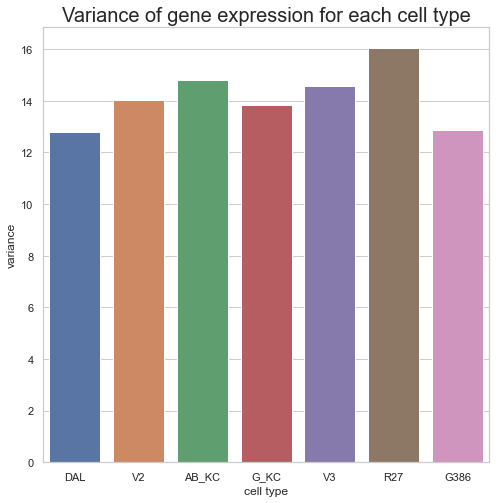

In [29]:
# Plot variances in a bar plot
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('Variance of gene expression for each cell type', fontsize = 20)
ax = sns.barplot(x='cell type', y='variance', data=variances_cell_types)

## Variance across genes

In [30]:
variances_cognition_genes = pd.DataFrame()
variances_cognition_genes['gene'] = avg_neuron_samples.index
variances_cognition_genes

,gene
0,14-3-3zeta
1,2mit
2,5-HT1A
3,Abl
4,Adf1
...,...
132,vn
133,vsg
134,w
135,wg


In [31]:
avg_neuron_samples.var(axis=1)

genes
14-3-3zeta    0.459868
2mit          0.664218
5-HT1A        0.817511
Abl           1.102346
Adf1          0.549364
                ...   
vn            2.502414
vsg           0.134467
w             6.483150
wg            0.000000
wnd           0.304371
Length: 137, dtype: float64

In [32]:
variances_cognition_genes['variance'] = avg_neuron_samples.var(axis=1).values
variances_cognition_genes.sort_values(by=['variance'], ascending=False, inplace=True)
variances_cognition_genes.head()

,gene,variance
95,prt,20.984335
102,rad,13.956869
130,trp,12.632349
60,Hn,11.981355
77,neur,10.562586


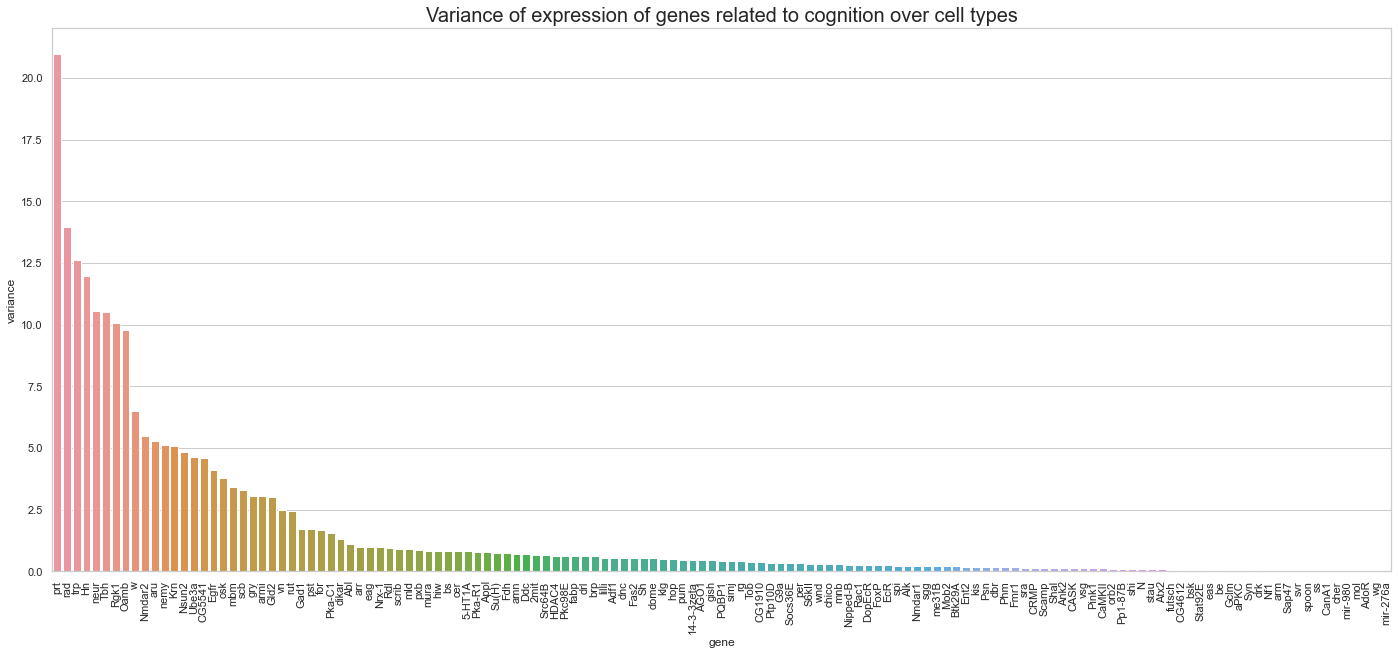

In [33]:
# Plot variances in a bar plot
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize = (24,10))
ax = fig.add_subplot(1,1,1) 
ax.set_title('Variance of expression of genes related to cognition over cell types', fontsize = 20)
ax = sns.barplot(x='gene', y='variance', data=variances_cognition_genes)
ax.set_xticklabels(labels=variances_cognition_genes['gene'],rotation=90);

## Same for the most variable genes related to cognition

In [34]:
# Most variable genes related to cognition from the previous analysis
avg_top_cognition = avg_neuron_samples.loc[avg_neuron_samples.index.intersection(top_cognition_neuron_gene_names),:]  
print(top_cognition_neuron_gene_names)
avg_top_cognition  

['Pka-C1', 'pum', 'Btk29A', 'bs', 'Ptp10D', 'me31B', 'hop', 'wcy', 'Gld2', 'dome']


,DAL,V2,AB_KC,G_KC,V3,R27,G386
bs,3.546622,4.240483,5.148118,5.030976,3.739681,3.472680,2.588844
Btk29A,8.110435,7.696812,7.151302,7.419878,8.199937,7.702526,6.991086
dome,7.103859,5.944056,6.603990,6.428368,6.106264,4.781846,5.879960
Gld2,0.000000,0.000000,3.053886,2.851573,3.724627,0.000000,0.000000
hop,5.940300,6.759637,7.065392,6.836829,5.544382,5.840975,5.238997
me31B,9.788344,10.048358,9.945631,10.132135,9.429479,9.149862,8.950986
Pka-C1,11.076377,11.904120,13.857627,13.695792,11.523995,11.025744,11.042973
Ptp10D,8.130703,8.452368,6.774573,7.444812,7.996425,7.511375,8.340323
pum,12.279827,12.949040,13.757641,13.310378,12.323619,12.059894,11.954633


In [35]:
# Variance over cell types
top_variances_cell_types = pd.DataFrame()
top_variances_cell_types['cell type'] = avg_top_cognition.columns
top_variances_cell_types['variance'] = top_variances_cell_types['cell type'].apply(lambda x: avg_top_cognition[x].var())
top_variances_cell_types

,cell type,variance
0,DAL,14.481880
1,V2,15.793066
2,AB_KC,13.585539
3,G_KC,13.103776
4,V3,9.743480
5,R27,14.332047
6,G386,14.857619


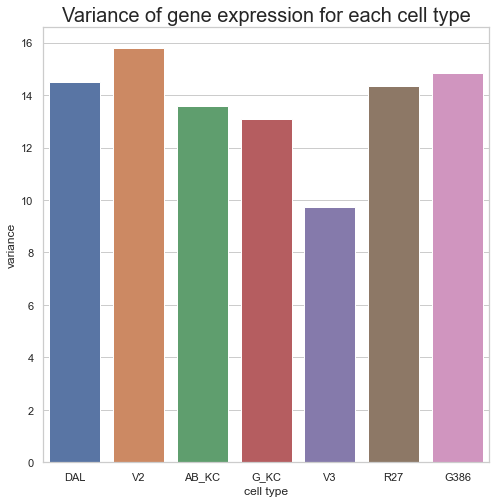

In [36]:
# Plot variances in a bar plot
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('Variance of gene expression for each cell type', fontsize = 20)
ax = sns.barplot(x='cell type', y='variance', data=top_variances_cell_types)

In [37]:
# Now variance across genes
top_variances_cognition_genes = pd.DataFrame()
top_variances_cognition_genes['gene'] = avg_top_cognition.index
top_variances_cognition_genes['variance'] = avg_top_cognition.var(axis=1).values
top_variances_cognition_genes.sort_values(by=['variance'], ascending=False, inplace=True)
top_variances_cognition_genes

,gene,variance
3,Gld2,3.013695
6,Pka-C1,1.546355
0,bs,0.828989
2,dome,0.529455
4,hop,0.502176
8,pum,0.471112
7,Ptp10D,0.354346
5,me31B,0.213915
1,Btk29A,0.207360


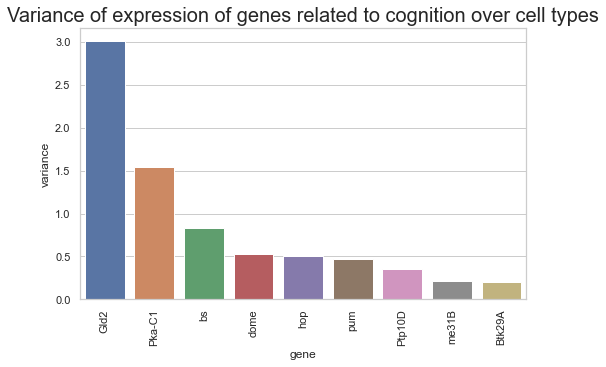

In [38]:
# Plot variances in a bar plot
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(1,1,1) 
ax.set_title('Variance of expression of genes related to cognition over cell types', fontsize = 20)
ax = sns.barplot(x='gene', y='variance', data=top_variances_cognition_genes)
ax.set_xticklabels(labels=top_variances_cognition_genes['gene'],rotation=90);

# PCA and clustering

Try to cluster cells / neuron types based on these expression values for genes related to cognition:

In [39]:
# All genes related to cognition
neuron_samples_cognition.set_index('genes', inplace=True)
neuron_samples_cognition.index.name = None
neuron_samples_cognition_T = neuron_samples_cognition.T.copy()
neuron_samples_cognition_T.index.name = 'cell'
neuron_samples_cognition_T.reset_index(inplace=True)
neuron_samples_cognition_T['cell type'] = neuron_samples_cognition_T['cell'].apply(lambda x: x[:3])
neuron_samples_cognition_T.head()

,cell,14-3-3zeta,2mit,5-HT1A,Abl,Adf1,AdoR,AGO1,Alk,amn,...,Tbh,Tob,trp,Ube3a,vn,vsg,w,wg,wnd,cell type
0,DAL1,14.212799,9.262948,7.083970,7.130445,9.373477,0.0,11.229356,11.228775,5.774189,...,1.003780,11.249307,7.779269,3.311587,0.0,10.665882,3.470345,0.0,3.849893,DAL
1,DAL2,14.260488,10.448570,6.178956,8.389671,7.966143,0.0,12.056127,12.110813,2.334330,...,1.016886,12.116307,7.887395,6.395309,0.0,10.997563,5.426585,0.0,8.000758,DAL
2,DAL3,14.514515,9.739787,8.598664,7.452564,7.359539,0.0,11.730539,12.197327,5.884744,...,5.342542,11.480758,6.663791,3.344075,0.0,11.525662,4.714065,0.0,6.500211,DAL
3,DAL4,14.834518,10.992330,8.999477,7.770638,8.510149,0.0,12.117740,11.887210,4.520974,...,3.266073,12.433218,4.402603,6.933572,0.0,10.641098,4.408415,0.0,5.561839,DAL
4,DAL5,14.645589,10.625359,6.751247,6.818213,8.694008,0.0,11.753633,11.617300,4.871155,...,5.431536,11.328080,7.546698,5.258504,0.0,10.958804,5.830682,0.0,6.037066,DAL


In [40]:
# First define an integer encoding for cell types
char_to_int_labels_mapping = dict(zip(neuron_samples_cognition_T['cell type'].unique(), range(N_CLASSES)))
print(char_to_int_labels_mapping)

{'DAL': 0, 'V2_': 1, 'AB_': 2, 'G_K': 3, 'V3_': 4, 'R27': 5, 'G38': 6}


In [41]:
# Define also the inverse mapping
int_to_char_labels_mapping = dict(zip(char_to_int_labels_mapping.values(), char_to_int_labels_mapping.keys()))
print(int_to_char_labels_mapping)

{0: 'DAL', 1: 'V2_', 2: 'AB_', 3: 'G_K', 4: 'V3_', 5: 'R27', 6: 'G38'}


In [42]:
# Now convert the cell type column to integers
neuron_samples_cognition_T['cell type'] = neuron_samples_cognition_T['cell type'].map(char_to_int_labels_mapping)
neuron_samples_cognition_T.head()

,cell,14-3-3zeta,2mit,5-HT1A,Abl,Adf1,AdoR,AGO1,Alk,amn,...,Tbh,Tob,trp,Ube3a,vn,vsg,w,wg,wnd,cell type
0,DAL1,14.212799,9.262948,7.083970,7.130445,9.373477,0.0,11.229356,11.228775,5.774189,...,1.003780,11.249307,7.779269,3.311587,0.0,10.665882,3.470345,0.0,3.849893,0
1,DAL2,14.260488,10.448570,6.178956,8.389671,7.966143,0.0,12.056127,12.110813,2.334330,...,1.016886,12.116307,7.887395,6.395309,0.0,10.997563,5.426585,0.0,8.000758,0
2,DAL3,14.514515,9.739787,8.598664,7.452564,7.359539,0.0,11.730539,12.197327,5.884744,...,5.342542,11.480758,6.663791,3.344075,0.0,11.525662,4.714065,0.0,6.500211,0
3,DAL4,14.834518,10.992330,8.999477,7.770638,8.510149,0.0,12.117740,11.887210,4.520974,...,3.266073,12.433218,4.402603,6.933572,0.0,10.641098,4.408415,0.0,5.561839,0
4,DAL5,14.645589,10.625359,6.751247,6.818213,8.694008,0.0,11.753633,11.617300,4.871155,...,5.431536,11.328080,7.546698,5.258504,0.0,10.958804,5.830682,0.0,6.037066,0


In [43]:
# Most variable genes related to cognition
top_cognition_neuron_samples.set_index('genes', inplace=True)
top_cognition_neuron_samples.index.name = None
top_cognition_neuron_samples_T = top_cognition_neuron_samples.T.copy()
top_cognition_neuron_samples_T.index.name = 'cell'
top_cognition_neuron_samples_T.reset_index(inplace=True)
top_cognition_neuron_samples_T['cell type'] = top_cognition_neuron_samples_T['cell'].apply(lambda x: x[:3])
top_cognition_neuron_samples_T['cell type'] = top_cognition_neuron_samples_T['cell type'].map(char_to_int_labels_mapping)
top_cognition_neuron_samples_T.head()

,cell,bs,Btk29A,dome,Gld2,hop,me31B,Pka-C1,Ptp10D,pum,cell type
0,DAL1,1.935444,6.406019,7.975098,0.0,7.401410,9.874500,10.828280,6.003185,11.805290,0
1,DAL2,1.941303,7.389764,6.953414,0.0,5.603299,10.139651,11.223611,8.680308,12.018523,0
2,DAL3,3.161840,8.884758,6.212854,0.0,3.729422,9.493569,11.165410,7.804389,12.286553,0
3,DAL4,3.922741,8.026315,6.891352,0.0,5.007611,8.749860,11.445373,8.585780,12.424672,0
4,DAL5,4.663298,8.276821,8.349425,0.0,6.357446,9.310242,10.293731,9.006296,12.075341,0


## PCA

First perform PCA with 2 components to visualize data in 2D space

All genes related to cognition:

In [44]:
# Reduce the dimensionality of the data to make it visualizable in 2D
pca_2D_all = PCA(n_components = 2)
columns = neuron_samples_cognition_T[neuron_samples_cognition_T.columns[1:-1]].copy()
X_principal_all_2D = pca_2D_all.fit_transform(columns)
X_principal_all_2D = pd.DataFrame(X_principal_all_2D, neuron_samples_cognition_T.index)
X_principal_all_2D.columns = ['PC1', 'PC2']
X_principal_targets_all_2D = pd.merge(X_principal_all_2D, neuron_samples_cognition_T['cell type'], left_index=True, right_index=True)
X_principal_targets_all_2D

,PC1,PC2,cell type
0,7.790246,1.332342,0
1,7.001417,1.175973,0
2,5.586894,3.631832,0
3,0.445582,3.457643,0
4,3.582243,4.363022,0
...,...,...,...
64,9.704361,-4.381222,6
65,9.628589,1.088162,6
66,13.188012,-2.977117,6
67,8.451199,-3.798017,6


In [45]:
cell_types = list(X_principal_targets_all_2D['cell type'].unique())
cell_types

[0, 1, 2, 3, 4, 5, 6]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

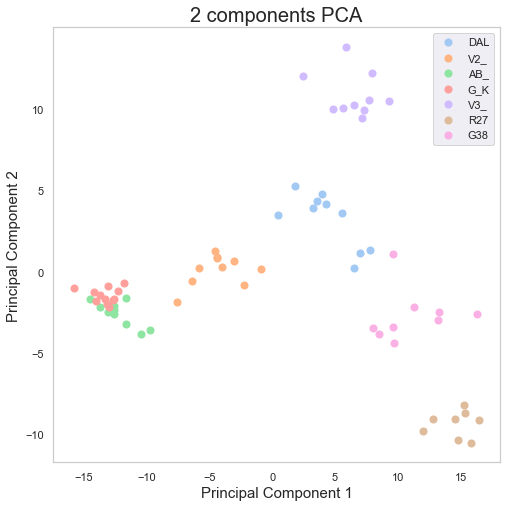

In [46]:
# Plot the PCA
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
sns.set_theme()
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 components PCA', fontsize = 20)
targets = cell_types
colors = sns.color_palette('pastel', len(targets))
for target, color in zip(targets,colors):
    indicesToKeep = X_principal_targets_all_2D['cell type'] == target
    ax.scatter(X_principal_targets_all_2D.loc[indicesToKeep, 'PC1']
               , X_principal_targets_all_2D.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(list(map(int_to_char_labels_mapping.get, targets))) # apply inverse mapping to print the cell types in characters
ax.grid()

In [47]:
print(pca_2D_all.explained_variance_ratio_)

[0.41294935 0.12322691]


In [48]:
neuron_samples_cognition_T[neuron_samples_cognition_T.columns[1:-1]].shape

(69, 137)

In [49]:
eigenvectors_all_2D = pd.DataFrame(pca_2D_all.components_, columns = neuron_samples_cognition_T.columns[1:-1])
eigenvectors_all_2D.index = ['PC1', 'PC2']
eigenvectors_all_2D = eigenvectors_all_2D.T.copy()
eigenvectors_all_2D['PC1'] = np.abs(eigenvectors_all_2D['PC1'])
eigenvectors_all_2D['PC2'] = np.abs(eigenvectors_all_2D['PC2'])
pc1_all_2D_main = pd.DataFrame(eigenvectors_all_2D.sort_values(by=['PC1'], ascending = False).head(10)) # 10 first eigenvectors
pc1_all_2D_main.index.name = 'genes'
pc1_all_2D_main.reset_index(inplace=True)
pc2_all_2D_main = pd.DataFrame(eigenvectors_all_2D.sort_values(by=['PC2'], ascending = False).head(10)) # 10 first eigenvectors
pc2_all_2D_main.index.name = 'genes'
pc2_all_2D_main.reset_index(inplace=True)
pc1_all_2D_main

,genes,PC1,PC2
0,prt,0.377592,0.100954
1,Hn,0.275738,0.032715
2,rad,0.263088,0.202432
3,Oamb,0.228255,0.175417
4,neur,0.201911,0.112152
5,Rgk1,0.197117,0.358130
6,aru,0.194779,0.045031
7,trp,0.193937,0.323363
8,w,0.162612,0.112348
9,Nmdar2,0.158173,0.212522


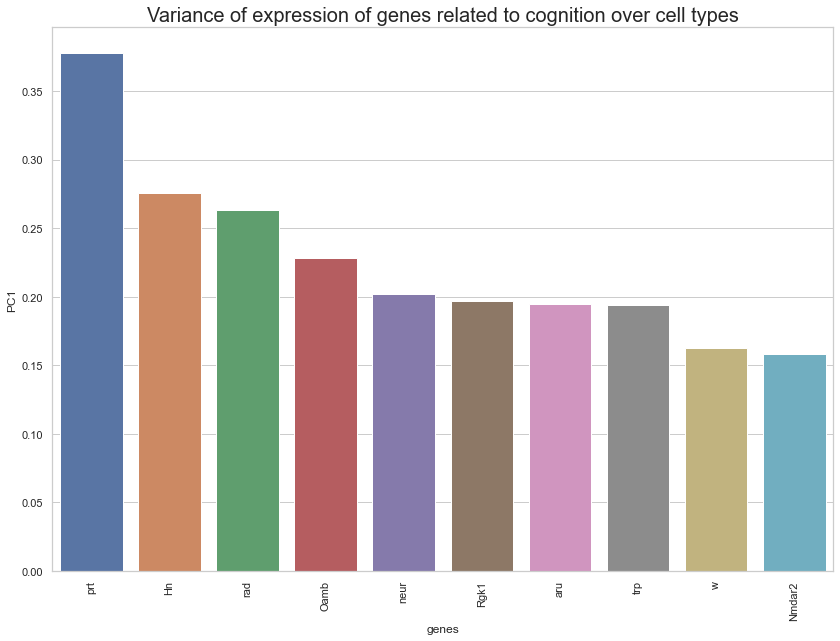

In [50]:
# Plot genes contributing the most to PC1
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(1,1,1) 
ax.set_title('Variance of expression of genes related to cognition over cell types', fontsize = 20)
ax = sns.barplot(x='genes', y='PC1', data=pc1_all_2D_main)
ax.set_xticklabels(labels=pc1_all_2D_main['genes'],rotation=90);

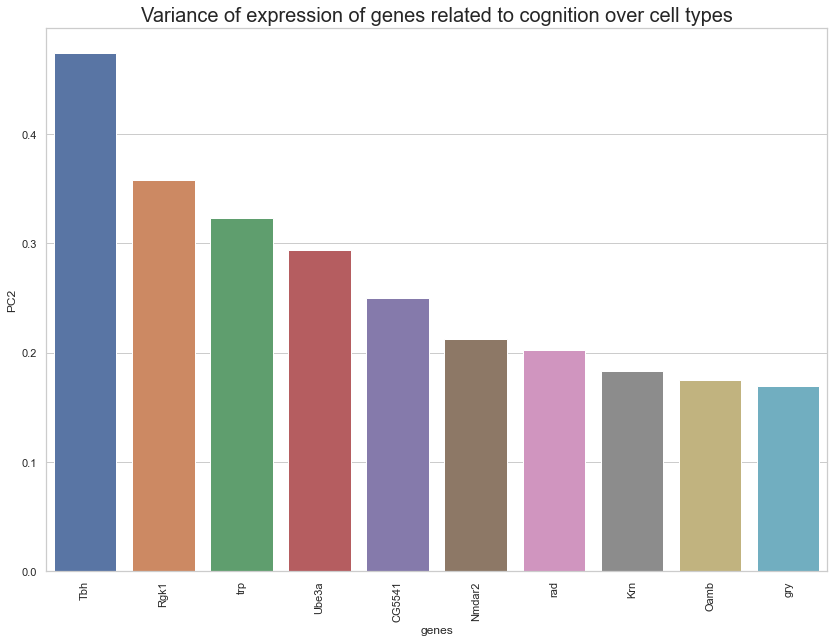

In [51]:
# # Plot genes contributing the most to PC2
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(1,1,1) 
ax.set_title('Variance of expression of genes related to cognition over cell types', fontsize = 20)
ax = sns.barplot(x='genes', y='PC2', data=pc2_all_2D_main)
ax.set_xticklabels(labels=pc2_all_2D_main['genes'],rotation=90);

Now look at the principal components that explain the most the variance:

In [52]:
pca_explained_variance_all = PCA()
X_principal_all = pca_explained_variance_all.fit_transform(columns)
X_principal_all = pd.DataFrame(X_principal_all, neuron_samples_cognition_T.index)
X_principal_targets_all = pd.merge(X_principal_all, neuron_samples_cognition_T['cell type'], left_index=True, right_index=True)
X_principal_targets_all.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,cell type
0,7.790246,1.332342,8.947100,-4.590443,-3.342210,-0.070747,2.223467,3.283444,0.914863,-1.258912,...,-0.049548,0.072548,-0.020511,-0.019762,-0.055657,-0.026807,-0.024696,-0.011599,1.080978e-14,0
1,7.001417,1.175973,9.663473,-4.157323,1.242381,-0.371889,-2.537565,-3.435662,2.841895,-2.095011,...,-0.074288,-0.087948,-0.046511,-0.001263,0.032905,0.029049,-0.016080,0.000743,1.080978e-14,0
2,5.586894,3.631832,7.092440,-6.020276,-1.156224,-0.725172,0.194894,-1.719831,0.131444,4.767024,...,0.021467,0.034590,0.034775,0.014543,-0.042854,-0.004405,-0.019122,-0.013209,1.080978e-14,0
3,0.445582,3.457643,5.924901,-4.705225,0.489967,-1.734438,0.161792,1.045116,-0.445763,-3.522530,...,0.025128,0.046025,0.053182,0.043591,-0.012721,0.002210,0.022838,-0.014532,1.080978e-14,0
4,3.582243,4.363022,8.216072,-5.012296,-2.581447,-1.269258,0.721510,1.391090,3.700315,-2.267631,...,-0.028501,0.061253,-0.060015,0.028059,0.000316,0.029879,0.012710,0.003417,1.080978e-14,0


In [53]:
explained_variance_all = pd.DataFrame(np.cumsum(pca_explained_variance_all.explained_variance_ratio_)*100, columns=['% of explained variance'])
explained_variance_all['component'] = np.arange(1, explained_variance_all.shape[0] + 1)
explained_variance_all

,% of explained variance,component
0,41.294935,1
1,53.617627,2
2,60.881805,3
3,66.624098,4
4,70.547052,5
...,...,...
64,99.986360,65
65,99.992007,66
66,99.996727,67
67,100.000000,68


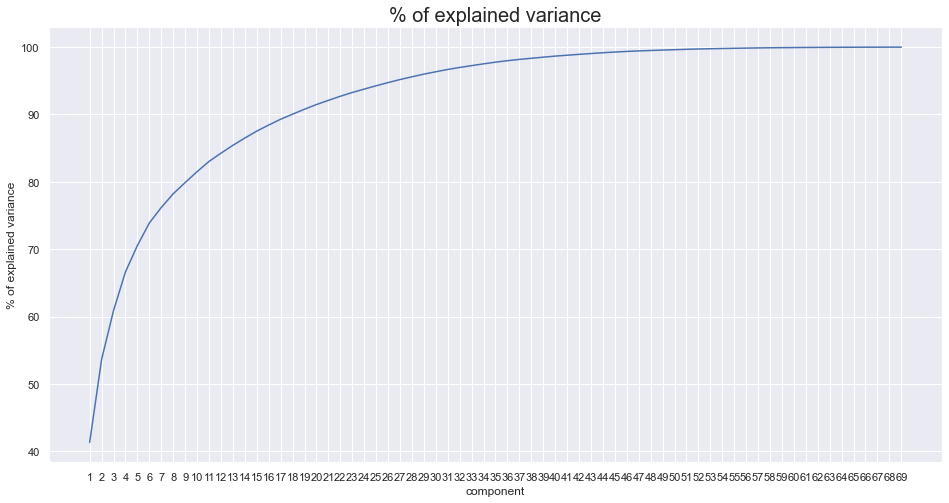

In [54]:
# Plot the resulting cumulative explained variance wrt components
sns.set_theme()
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('% of explained variance', fontsize = 20)
ax.set(xticks=explained_variance_all.component)
ax = sns.lineplot(x='component', y='% of explained variance', data=explained_variance_all)

Let's keep for example 90% of the variance, and later cluster thus with the 18 first principal components.

In [55]:
pca_18D_all = PCA(n_components=18)
X_principal_all_18D = pca_18D_all.fit_transform(columns)
X_principal_all_18D = pd.DataFrame(X_principal_all_18D, neuron_samples_cognition_T.index)
X_principal_targets_all_18D = pd.merge(X_principal_all_18D, neuron_samples_cognition_T['cell type'], left_index=True, right_index=True)
X_principal_targets_all_18D.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,cell type
0,7.790246,1.332342,8.947100,-4.590443,-3.342210,-0.070747,2.223467,3.283444,0.914863,-1.258912,2.686194,-2.029713,0.557444,-0.487595,-1.093210,-1.825835,0.151154,2.419599,0
1,7.001417,1.175973,9.663473,-4.157323,1.242381,-0.371889,-2.537565,-3.435662,2.841895,-2.095011,1.832212,-2.432446,1.048975,3.163072,-1.320945,3.770322,-1.149347,-2.062881,0
2,5.586894,3.631832,7.092440,-6.020276,-1.156224,-0.725172,0.194894,-1.719831,0.131444,4.767024,2.815828,2.756862,2.879815,0.936286,-1.983807,0.281873,-1.325040,-3.316411,0
3,0.445582,3.457643,5.924901,-4.705225,0.489967,-1.734438,0.161792,1.045116,-0.445763,-3.522530,-1.735672,3.190948,-1.286908,-2.262433,-0.095901,0.437696,0.672054,0.795042,0
4,3.582243,4.363022,8.216072,-5.012296,-2.581447,-1.269258,0.721510,1.391090,3.700315,-2.267631,-2.021903,-1.852662,-3.472901,-4.087971,-0.549580,2.897355,-2.481579,-2.639849,0


With only the most variable genes related to cognition:

In [56]:
# Reduce the dimensionality of the data to make it visualizable in 2D
pca_2D_top = PCA(n_components=2)
columns_top = top_cognition_neuron_samples_T[top_cognition_neuron_samples_T.columns[1:-1]].copy()
X_principal_top_2D = pca_2D_top.fit_transform(columns_top)
X_principal_top_2D = pd.DataFrame(X_principal_top_2D, top_cognition_neuron_samples_T.index)
X_principal_top_2D.columns = ['PC1', 'PC2']
X_principal_targets_top_2D = pd.merge(X_principal_top_2D, top_cognition_neuron_samples_T['cell type'], left_index=True, right_index=True)
X_principal_targets_top_2D

,PC1,PC2,cell type
0,-2.024205,-1.046824,0
1,-2.558613,0.356683,0
2,-2.361393,1.181981,0
3,-1.800650,0.062318,0
4,-1.654873,-0.956385,0
...,...,...,...
64,-2.881361,0.606209,6
65,-1.673663,-0.542520,6
66,-1.841108,-0.204708,6
67,-3.202258,1.288929,6


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

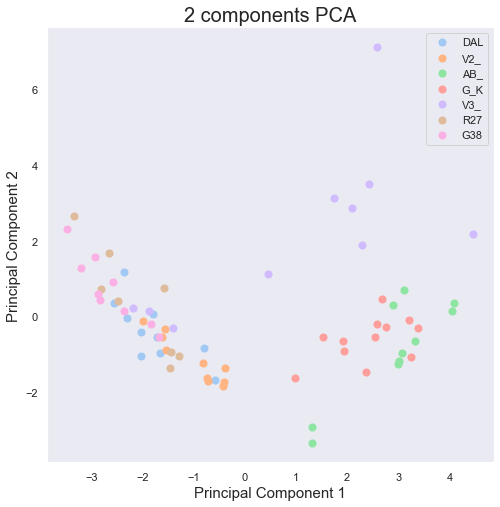

In [57]:
# Plot the PCA
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 components PCA', fontsize = 20)
targets = cell_types
colors = sns.color_palette('pastel', len(targets))
for target, color in zip(targets,colors):
    indicesToKeep = X_principal_targets_top_2D['cell type'] == target
    ax.scatter(X_principal_targets_top_2D.loc[indicesToKeep, 'PC1']
               , X_principal_targets_top_2D.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(list(map(int_to_char_labels_mapping.get, targets))) # apply inverse mapping to print the cell types in characters
ax.grid()

In [58]:
print(pca_2D_top.explained_variance_ratio_)

[0.42458687 0.19368399]


Now look at the principal components that explain the most the variance:

In [59]:
pca_explained_variance_top = PCA()
X_principal_top = pca_explained_variance_top.fit_transform(columns_top)
X_principal_top = pd.DataFrame(X_principal_top, neuron_samples_cognition_T.index)
X_principal_targets_top = pd.merge(X_principal_top, top_cognition_neuron_samples_T['cell type'], left_index=True, right_index=True)
X_principal_targets_top.head()

,0,1,2,3,4,5,6,7,8,cell type
0,-2.024205,-1.046824,-2.661498,1.337639,-0.383960,-1.414034,1.444227,-0.313445,-0.069161,0
1,-2.558613,0.356683,-1.011146,1.046899,-0.105662,0.722678,-0.218430,-0.642046,0.254671,0
2,-2.361393,1.181981,1.043327,0.695601,-1.363385,-0.381932,-1.138476,-0.104076,0.049154,0
3,-1.800650,0.062318,0.945240,1.018068,-0.488341,0.458166,-0.298341,0.795774,-0.000326,0
4,-1.654873,-0.956385,1.203725,2.672477,0.763354,0.149112,0.432766,0.147948,-0.138321,0


In [60]:
explained_variance_top = pd.DataFrame(np.cumsum(pca_explained_variance_top.explained_variance_ratio_)*100, columns=['% of explained variance'])
explained_variance_top['component'] = np.arange(1, explained_variance_top.shape[0] + 1)
explained_variance_top

,% of explained variance,component
0,42.458687,1
1,61.827086,2
2,73.978506,3
3,82.914353,4
4,89.687242,5
5,94.295428,6
6,97.698663,7
7,99.426086,8
8,100.000000,9


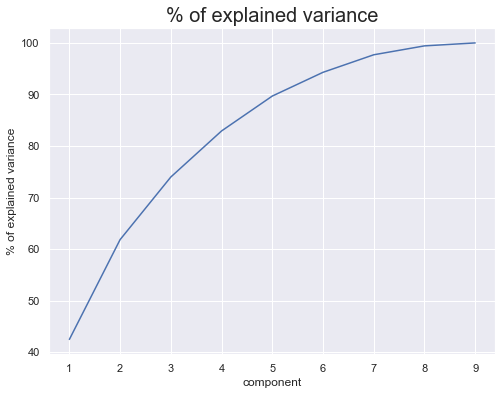

In [61]:
# Plot the resulting cumulative explained variance wrt components
sns.set_theme()
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_title('% of explained variance', fontsize = 20)
ax.set(xticks=explained_variance_top.component)
ax = sns.lineplot(x='component', y='% of explained variance', data=explained_variance_top)

Let's keep for example 90% of the variance, and later cluster thus with the 5 first principal components.

In [62]:
pca_18D_top = PCA(n_components=18)
X_principal_top_18D = pca_18D_all.fit_transform(columns)
X_principal_top_18D = pd.DataFrame(X_principal_top_18D, top_cognition_neuron_samples_T.index)
X_principal_targets_top_18D = pd.merge(X_principal_top_18D, top_cognition_neuron_samples_T['cell type'], left_index=True, right_index=True)
X_principal_targets_top_18D.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,cell type
0,7.790246,1.332342,8.947100,-4.590443,-3.342210,-0.070747,2.223467,3.283444,0.914863,-1.258912,2.686194,-2.029713,0.557444,-0.487595,-1.093210,-1.825835,0.151154,2.419599,0
1,7.001417,1.175973,9.663473,-4.157323,1.242381,-0.371889,-2.537565,-3.435662,2.841895,-2.095011,1.832212,-2.432446,1.048975,3.163072,-1.320945,3.770322,-1.149347,-2.062881,0
2,5.586894,3.631832,7.092440,-6.020276,-1.156224,-0.725172,0.194894,-1.719831,0.131444,4.767024,2.815828,2.756862,2.879815,0.936286,-1.983807,0.281873,-1.325040,-3.316411,0
3,0.445582,3.457643,5.924901,-4.705225,0.489967,-1.734438,0.161792,1.045116,-0.445763,-3.522530,-1.735672,3.190948,-1.286908,-2.262433,-0.095901,0.437696,0.672054,0.795042,0
4,3.582243,4.363022,8.216072,-5.012296,-2.581447,-1.269258,0.721510,1.391090,3.700315,-2.267631,-2.021903,-1.852662,-3.472901,-4.087971,-0.549580,2.897355,-2.481579,-2.639849,0


## OPTICS

In [63]:
def bootstrap(array, n, samples, confidence, mean = True, prob = 2):
    '''Bootstrapping method that computes IC for mean of a sample if mean = True
    or given probability if mean != True'''
    stats = []
    lower_bound = int(((1-confidence)/2)*samples)
    upper_bound = int(samples - lower_bound)
    
    for i in range(samples):
        resample = np.random.choice(array,n)
        if (not mean):
            count = Counter(resample)
            stat_resample = sum([count[x] for x in count.keys() if x <= -prob or x >= prob])/n
        else:
            stat_resample = np.mean(resample)
            
        stats.append(stat_resample)

    stats.sort()
    return [round(stats[lower_bound-1], 4), round(stats[upper_bound-1], 4)], np.mean(stats)

In [64]:
def training(train, test, model, features):
    '''Trains a given model and given features on a train set and tests it on the test set'''
    print(train)
    print(test)
    train_X = train[features]
    train_y = train[label].values.reshape(-1)
    
    test_X = test[features]
    test_y = test[label].values.reshape(-1)
    
    model.fit(train_X, train_y)
    y_pred = model.transform(test_X)
    r2 = r2_score(test_y, y_pred)
    return y_pred, r2

In [65]:
# Perform the k-fold cross validation and return the R^2 statistic
def KFold_cross_val(data, n_folds, model, features):
    '''Implements n-fold cross validation for a given dataset, model and features'''
    kf = KFold(n_splits=n_folds, random_state=None, shuffle=False)
    R2 = []
    for train_index, validation_index in kf.split(data):
        train, test = data.loc[train_index], data.loc[validation_index]
        _, r2= training(train, test, model, features)
        R2.append(r2)
    return R2

Perform OPTICS on all genes related to cognition but after dimensionality reduction of the data to its 18 first principal components:

In [66]:
"""
n_folds = 20
hyperparams = {'eps':[50, 75, 100, 150, 200, 250], 'min_samples':[0.1, 0.05, 0.01]} # Change the values
features = X_principal_all_18D.columns
label = 'cell type'

scenarios = []

print('Cross validation results for DBSCAN parameters:')
# For each possible combination of hyperparameters, perform a 20-fold cross validation
for eps_ in hyperparams['eps']:
    for min_samples_ in hyperparams['min_samples']:
        r2 = KFold_cross_val(X_principal_targets_all_18D, n_folds, DBSCAN(eps=eps_, min_samples=min_samples_), features)
        r2_IC, r2_mean = bootstrap(r2, len(r2), 100, 0.9, mean = True)
        scenario = {'learning_rate':lr, 'n_estimators':n, 'Mean r2': r2_mean, '90% CI': r2_IC}
        print(scenario)
        scenarios.append(scenario)
        
"""

"\nn_folds = 20\nhyperparams = {'eps':[50, 75, 100, 150, 200, 250], 'min_samples':[0.1, 0.05, 0.01]} # Change the values\nfeatures = X_principal_all_18D.columns\nlabel = 'cell type'\n\nscenarios = []\n\nprint('Cross validation results for DBSCAN parameters:')\n# For each possible combination of hyperparameters, perform a 20-fold cross validation\nfor eps_ in hyperparams['eps']:\n    for min_samples_ in hyperparams['min_samples']:\n        r2 = KFold_cross_val(X_principal_targets_all_18D, n_folds, DBSCAN(eps=eps_, min_samples=min_samples_), features)\n        r2_IC, r2_mean = bootstrap(r2, len(r2), 100, 0.9, mean = True)\n        scenario = {'learning_rate':lr, 'n_estimators':n, 'Mean r2': r2_mean, '90% CI': r2_IC}\n        print(scenario)\n        scenarios.append(scenario)\n        \n"

In [67]:
# Clustering with DBSCAN (no arbitrary choice of the number of cluster k and of eps as in DBSCAN)
#eps_DBSCAN, min_samples_DBSCAN = 2, 2*len(X_principal_all_18D.columns) # (advice found on stack overflow)

In [68]:
classifier_1 = OPTICS(min_samples=5)
OPTICS_model = classifier_1.fit(X_principal_all_18D[X_principal_all_18D.columns])
labels_1 = OPTICS_model.labels_
print(labels_1)

[ 0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  1  1  1  1  1  1
  1  1  1  1  6  6  6  6  6  6  6  6 -1  5  5  5  5  5  5  5 -1]


In [69]:
X_OPTICS = pd.DataFrame(X_principal_all_18D).copy()
X_OPTICS['OPTICS'] = labels_1
X_OPTICS

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,OPTICS
0,7.790246,1.332342,8.947100,-4.590443,-3.342210,-0.070747,2.223467,3.283444,0.914863,-1.258912,2.686194,-2.029713,0.557444,-0.487595,-1.093210,-1.825835,0.151154,2.419599,0
1,7.001417,1.175973,9.663473,-4.157323,1.242381,-0.371889,-2.537565,-3.435662,2.841895,-2.095011,1.832212,-2.432446,1.048975,3.163072,-1.320945,3.770322,-1.149347,-2.062881,0
2,5.586894,3.631832,7.092440,-6.020276,-1.156224,-0.725172,0.194894,-1.719831,0.131444,4.767024,2.815828,2.756862,2.879815,0.936286,-1.983807,0.281873,-1.325040,-3.316411,0
3,0.445582,3.457643,5.924901,-4.705225,0.489967,-1.734438,0.161792,1.045116,-0.445763,-3.522530,-1.735672,3.190948,-1.286908,-2.262433,-0.095901,0.437696,0.672054,0.795042,0
4,3.582243,4.363022,8.216072,-5.012296,-2.581447,-1.269258,0.721510,1.391090,3.700315,-2.267631,-2.021903,-1.852662,-3.472901,-4.087971,-0.549580,2.897355,-2.481579,-2.639849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,9.704361,-4.381222,3.894211,7.068014,-1.292165,2.957431,3.794536,-1.068596,0.278024,0.668933,-4.151201,0.220668,3.608028,1.738462,1.832669,0.906403,-1.261756,0.474507,5
65,9.628589,1.088162,5.781836,6.840750,1.425636,4.276843,2.664011,-2.160367,3.280265,0.576785,-4.062031,-0.474226,-0.487884,-0.698282,-1.080296,-2.980965,4.807932,-0.977023,5
66,13.188012,-2.977117,8.197979,3.797882,-0.103026,0.813540,-3.006037,-1.100027,-0.462308,4.897133,-2.610971,0.268987,-1.430629,4.980023,-0.771977,-1.280349,-1.709221,2.199567,5
67,8.451199,-3.798017,0.374628,10.110643,-2.732152,1.496212,2.412492,-1.796276,-1.674401,-3.275317,4.211734,0.201939,-1.374782,0.303419,-4.527652,2.214615,-1.993805,2.242419,5


In [70]:
""" A clustering result satisfies completeness if all the data points that are members of a given class
are elements of the same cluster. """
print('Completeness score: ' + str(completeness_score(X_principal_targets_all_18D['cell type'], X_OPTICS['OPTICS'])))

Completeness score: 0.9656004823843293


In [71]:
"""The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b)
for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). 
To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. 
The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. 
Negative values generally indicate that a sample has been assigned to the wrong cluster, 
as a different cluster is more similar."""
print('Silhouette Coefficient: ' + str(silhouette_score(X_principal_all_18D, X_OPTICS['OPTICS'])))

Silhouette Coefficient: 0.4115189867756887


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

[ 0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  1  1  1  1  1  1
  1  1  1  1  6  6  6  6  6  6  6  6 -1  5  5  5  5  5  5  5 -1]


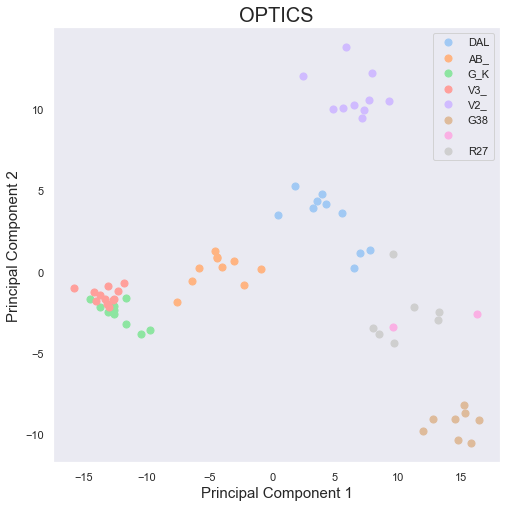

In [72]:
# Plot OPTICS results wrt to the first 2 principal components
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('OPTICS', fontsize = 20)

print(labels_1)
targets = Counter(labels_1).keys()
colors = sns.color_palette('pastel', len(Counter(targets).keys()))

for target, color in zip(targets,colors):
    indicesToKeep = X_OPTICS['OPTICS'] == target
    ax.scatter(X_OPTICS.loc[indicesToKeep, X_OPTICS.columns[0]]
               , X_OPTICS.loc[indicesToKeep, X_OPTICS.columns[1]]
               , c = color
               , s = 50)
    
ax.legend(list(map(int_to_char_labels_mapping.get, targets))) # apply inverse mapping to print the cell types in characters
ax.grid()

In [73]:
# Now bootstrap to choose the best number of min_samples

In [74]:
hyperparams = {'min_samples': [2,4,6,8]} # Change the values
features = X_principal_all_18D.columns
label = 'cell type'

scenarios = []

print('Bootstrap clustering performance estimates for OPTICS:')
for min_samples_ in hyperparams['min_samples']:
    #completeness_score = 
    #completeness_IC, completeness_mean = bootstrap(completeness_score, len(completeness_score), 100, 0.9, mean = True)
    scenario = {'min_samples': min_samples_, 'Mean completeness': completeness_mean, '90% CI completeness': completeness_IC}
    print(scenario)
    scenarios.append(scenario)

Bootstrap clustering performance estimates for OPTICS:


NameError: name 'completeness_mean' is not defined

## K-means

In [75]:
# Try with k-means (but probably overfits by setting the hyperparameter n_clusters to the actual true number of clusters)
kmeans = KMeans(n_clusters=7, random_state=0)
model_KMeans = kmeans.fit(X_principal_all_18D)

In [76]:
labels_KMeans = model_KMeans.labels_
X_KMeans = pd.DataFrame(X_principal_all_18D).copy()
X_KMeans['KMeans'] = labels_KMeans

In [77]:
X_KMeans

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,KMeans
0,7.790246,1.332342,8.947100,-4.590443,-3.342210,-0.070747,2.223467,3.283444,0.914863,-1.258912,2.686194,-2.029713,0.557444,-0.487595,-1.093210,-1.825835,0.151154,2.419599,6
1,7.001417,1.175973,9.663473,-4.157323,1.242381,-0.371889,-2.537565,-3.435662,2.841895,-2.095011,1.832212,-2.432446,1.048975,3.163072,-1.320945,3.770322,-1.149347,-2.062881,6
2,5.586894,3.631832,7.092440,-6.020276,-1.156224,-0.725172,0.194894,-1.719831,0.131444,4.767024,2.815828,2.756862,2.879815,0.936286,-1.983807,0.281873,-1.325040,-3.316411,6
3,0.445582,3.457643,5.924901,-4.705225,0.489967,-1.734438,0.161792,1.045116,-0.445763,-3.522530,-1.735672,3.190948,-1.286908,-2.262433,-0.095901,0.437696,0.672054,0.795042,6
4,3.582243,4.363022,8.216072,-5.012296,-2.581447,-1.269258,0.721510,1.391090,3.700315,-2.267631,-2.021903,-1.852662,-3.472901,-4.087971,-0.549580,2.897355,-2.481579,-2.639849,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,9.704361,-4.381222,3.894211,7.068014,-1.292165,2.957431,3.794536,-1.068596,0.278024,0.668933,-4.151201,0.220668,3.608028,1.738462,1.832669,0.906403,-1.261756,0.474507,2
65,9.628589,1.088162,5.781836,6.840750,1.425636,4.276843,2.664011,-2.160367,3.280265,0.576785,-4.062031,-0.474226,-0.487884,-0.698282,-1.080296,-2.980965,4.807932,-0.977023,2
66,13.188012,-2.977117,8.197979,3.797882,-0.103026,0.813540,-3.006037,-1.100027,-0.462308,4.897133,-2.610971,0.268987,-1.430629,4.980023,-0.771977,-1.280349,-1.709221,2.199567,2
67,8.451199,-3.798017,0.374628,10.110643,-2.732152,1.496212,2.412492,-1.796276,-1.674401,-3.275317,4.211734,0.201939,-1.374782,0.303419,-4.527652,2.214615,-1.993805,2.242419,2


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

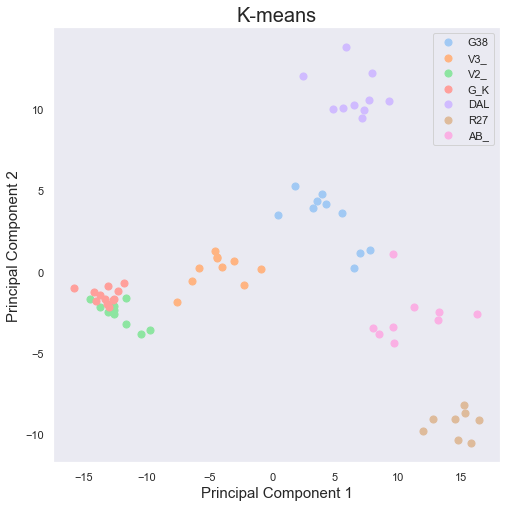

In [78]:
# Plot the resulting clustering wrt to the first 2 principal components
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('K-means', fontsize = 20)

targets = Counter(labels_KMeans).keys()
colors = sns.color_palette('pastel', len(Counter(targets).keys()))

for target, color in zip(targets,colors):
    indicesToKeep = X_KMeans['KMeans'] == target
    ax.scatter(X_KMeans.loc[indicesToKeep, X_KMeans.columns[0]]
               , X_KMeans.loc[indicesToKeep, X_KMeans.columns[1]]
               , c = color
               , s = 50)
ax.legend(list(map(int_to_char_labels_mapping.get, targets))) # apply inverse mapping to print the cell types in characters
ax.grid()

## City block metric 

In [79]:
# Try with city block distance metric
distance_matrix = distance.cdist(columns, columns, 'cityblock')
distance_matrix.shape

(69, 69)

Text(0.5, 1.0, 'Distance matrix (city block)')

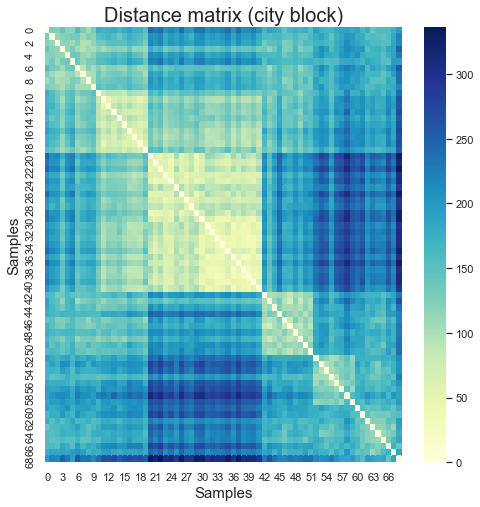

In [80]:
# Plot the resulting distance matrix
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax = sns.heatmap(distance_matrix, cmap="YlGnBu")
ax.set_xlabel('Samples', fontsize = 15)
ax.set_ylabel('Samples', fontsize = 15)
ax.set_title('Distance matrix (city block)', fontsize = 20)

In [81]:
# Select random templates for the classification
def select_random_templates():
    
    template_names = []

    DAL_template = random.choice(DAL.columns)
    template_names.append(DAL_template)

    V2_template = random.choice(V2.columns)
    template_names.append(V2_template)

    AB_KC_template = random.choice(AB_KC.columns)
    template_names.append(AB_KC_template)

    G_KC_template = random.choice(G_KC.columns)
    template_names.append(G_KC_template)

    V3_template = random.choice(V3.columns)
    template_names.append(V3_template)

    R27_template = random.choice(R27.columns)
    template_names.append(R27_template)

    G386_template = random.choice(G386.columns)
    template_names.append(G386_template)
    
    return template_names

# Perform the k-NN classification based on templates
def k_NN(n_iter):
    
    neigh = KNeighborsClassifier(n_neighbors=3) ## do a cross val to choose number of neighbors n?
    conf_matrix = np.zeros((N_CLASSES, N_CLASSES))
    
    # Train the classifier on the templates (split train and test?)
    for i in range(n_iter):
        template_columns = neuron_samples.columns.intersection(select_random_templates())
        templates = neuron_samples[template_columns]
        y_templates = [char[:3] for char in templates.columns]

        cell_types = [char[:3] for char in neuron_samples_cognition.index]
        samples = neuron_samples_cognition[neuron_samples_cognition.columns[:-1]].to_numpy()
        neigh.fit(samples, cell_types)
        cell_types_pred = neigh.predict(samples)
        
        conf_matrix = np.add(conf_matrix, confusion_matrix(cell_types, cell_types_pred))
    
    conf_matrix = np.divide(conf_matrix, n_iter)    
    return conf_matrix
   
# Plot confusion matrix as an heatmap
def plot_confusion_matrix(conf_matrix):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax = sns.heatmap(conf_matrix, cmap="YlGnBu")
    ax.set_xlabel('Samples', fontsize = 15)
    ax.set_ylabel('Samples', fontsize = 15)
    ax.set_title('Confusion matrix (city block and k-NN)', fontsize = 20)

In [82]:
# Select random templates for the classification
def select_random_templates():
    
    template_names = []

    DAL_template = random.choice(DAL.columns)
    template_names.append(DAL_template)

    V2_template = random.choice(V2.columns)
    template_names.append(V2_template)

    AB_KC_template = random.choice(AB_KC.columns)
    template_names.append(AB_KC_template)

    G_KC_template = random.choice(G_KC.columns)
    template_names.append(G_KC_template)

    V3_template = random.choice(V3.columns)
    template_names.append(V3_template)

    R27_template = random.choice(R27.columns)
    template_names.append(R27_template)

    G386_template = random.choice(G386.columns)
    template_names.append(G386_template)
    
    return template_names

# Perform the k-NN classification based on templates
def k_NN(n_iter):
    
    neigh = KNeighborsClassifier(n_neighbors=3) ## do a cross val to choose number of neighbors n?
    conf_matrix = np.zeros((N_CLASSES, N_CLASSES))
    
    # Train the classifier on the templates (split train and test?)
    for i in range(n_iter):
        template_columns = neuron_samples_cognition.columns.intersection(select_random_templates())
        templates = neuron_samples_cognition[template_columns]
        y_templates = [char[:3] for char in templates.columns]
        neigh.fit(templates, y_templates)

        #test = neuron_samples_cognition.copy().co
        cell_types = [char[:3] for char in neuron_samples_cognition.index]
        samples = neuron_samples_cognition[neuron_samples_cognition.columns[:-1]].to_numpy()
        neigh.fit(samples, cell_types)
        cell_types_pred = neigh.predict(samples)
        
        conf_matrix = np.add(conf_matrix, confusion_matrix(cell_types, cell_types_pred))
    
    conf_matrix = np.divide(conf_matrix, n_iter)    
    return conf_matrix
   
# Plot confusion matrix as an heatmap
def plot_confusion_matrix(conf_matrix):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax = sns.heatmap(conf_matrix, cmap="YlGnBu")
    ax.set_xlabel('Samples', fontsize = 15)
    ax.set_ylabel('Samples', fontsize = 15)
    ax.set_title('Confusion matrix (city block and k-NN)', fontsize = 20)

In [ ]:
plot_confusion_matrix(k_NN(3))

In [ ]:
neuron_samples_cognition